In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Activation, Add, Multiply, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization

In [2]:
dataset_path = (r"C:\Users\spoor\OneDrive\Desktop\Brain-Tumor-Classification-DataSet-master")

# Define the training and testing directories
train_dir = os.path.join(dataset_path, (r"C:\Users\spoor\OneDrive\Desktop\Brain-Tumor-Classification-DataSet-master\Testing"))
test_dir = os.path.join(dataset_path, (r"C:\Users\spoor\OneDrive\Desktop\Brain-Tumor-Classification-DataSet-master\Training"))

# Define the categories
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

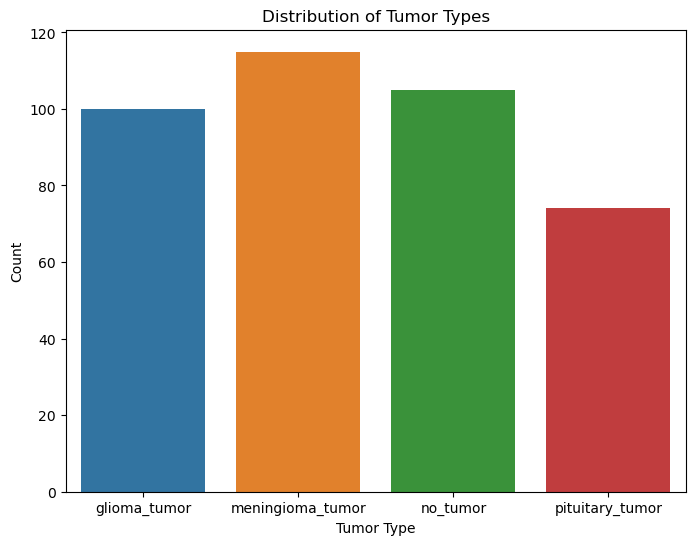

In [3]:
 # Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

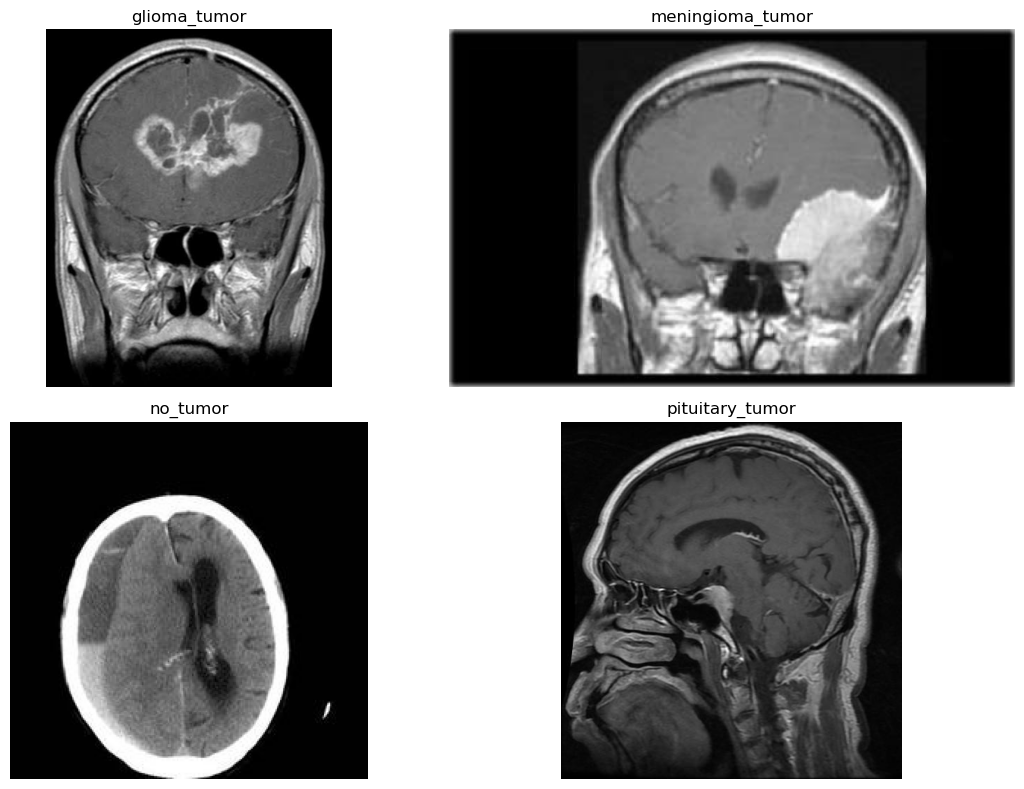

In [4]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [6]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 394 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.


In [7]:
# Function to create the DenseNet model
def create_densenet_model(input_shape, num_classes):
    base_model = DenseNet121(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

In [8]:
# Function to create the Attention CNN model
def create_attention_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Attention mechanism
    attention_data = Conv2D(128, (1, 1), activation='sigmoid')(x)
    attention_data = Multiply()([x, attention_data])
    x = Add()([x, attention_data])
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model


In [9]:
# Create and compile the models
input_shape = (image_size[0], image_size[1], 3)
num_classes = len(categories)

densenet_model = create_densenet_model(input_shape, num_classes)
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

attention_cnn_model = create_attention_cnn_model(input_shape, num_classes)
attention_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Train the models
history_densenet = densenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('densenet_model.keras', save_best_only=True)
    ]
)

history_attention_cnn = attention_cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('attention_cnn_model.keras', save_best_only=True)
    ]
)

Epoch 1/50


C:\Users\spoor\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 118s 9s/step - accuracy: 0.3776 - loss: 1.9987 - val_accuracy: 0.3933 - val_loss: 1.8460
Epoch 2/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.6000 - loss: 1.3090

C:\Users\spoor\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.6000 - loss: 1.3090 - val_accuracy: 0.3182 - val_loss: 1.1504
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 89s 8s/step - accuracy: 0.4912 - loss: 1.7301 - val_accuracy: 0.4164 - val_loss: 1.4186
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5938 - loss: 1.6160 - val_accuracy: 0.8636 - val_loss: 0.4663
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 89s 8s/step - accuracy: 0.5668 - loss: 1.1264 - val_accuracy: 0.4659 - val_loss: 1.3036
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.5312 - loss: 1.3373 - val_accuracy: 0.9545 - val_loss: 0.2744
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 89s 8s/step - accuracy: 0.6532 - loss: 0.8891 - val_accuracy: 0.4417 - val_loss: 1.3841
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4375 - loss: 1.0460 - val_accuracy: 0.7727 - val_loss: 0.8664
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 89s 8s/step - accuracy: 0.6580 - loss: 0.8482 - val_accuracy: 0.5499 - val_loss: 1.2

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
input_shape = (150, 150, 3)
num_classes = len(categories)

densenet_model = create_densenet_model(input_shape, num_classes)
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

attention_cnn_model = create_attention_cnn_model(input_shape, num_classes)
attention_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define GAN components

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build and compile GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

gan = Sequential([generator, discriminator])
discriminator.trainable = False
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Function to load real images from the dataset
def load_real_images(data_path, categories, image_size=(28, 28)):
    images = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            image = load_img(img_path, target_size=image_size, color_mode='grayscale')
            image = img_to_array(image)
            images.append(image)
    images = np.array(images)
    return images

# Example path and categories
dataset_path = r"C:\Users\spoor\OneDrive\Desktop\Brain-Tumor-Classification-DataSet-master\Training"
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Load and preprocess real images
real_images = load_real_images(dataset_path, categories)
real_images = real_images / 255.0

# Training the GAN
def train_gan(generator, discriminator, gan, real_images, epochs=10, batch_size=128):
    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)
        
        real_images_batch = real_images[np.random.randint(0, real_images.shape[0], batch_size)]
        labels_real = np.ones((batch_size, 1))
        labels_fake = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_images_batch, labels_real)
        d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        labels_gan = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, labels_gan)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: D Loss Real = {d_loss_real}, D Loss Fake = {d_loss_fake}, G Loss = {g_loss}")

# Train the GAN
train_gan(generator, discriminator, gan, real_images)

# Generate synthetic images
def generate_synthetic_images(generator, noise_dim, num_images):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]
    return generated_images

# Example to generate synthetic images
num_synthetic_images = 10
synthetic_images = generate_synthetic_images(generator, 100, num_synthetic_images)


C:\Users\spoor\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\spoor\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\spoor\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\spoor\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss Real = 0.697574257850647, D Loss Fake = 0.671887993812561, G Loss = [array(0.671888, dtype=float32), array(0.671888, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


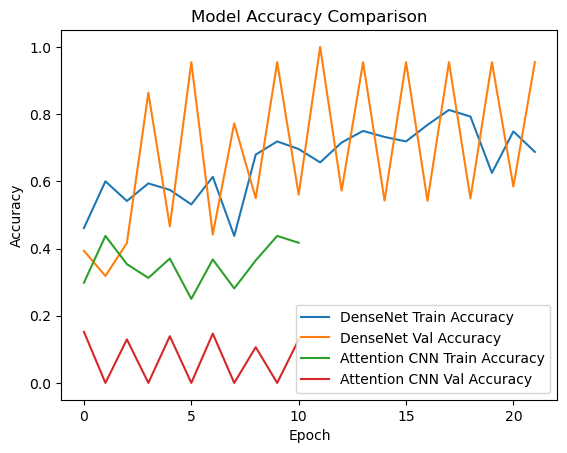

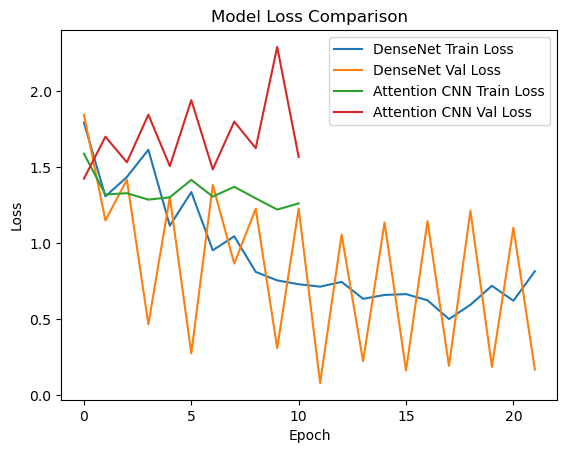

In [13]:
# Plot the training and validation accuracy for DenseNet and Attention CNN
plt.plot(history_densenet.history['accuracy'], label='DenseNet Train Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='DenseNet Val Accuracy')
plt.plot(history_attention_cnn.history['accuracy'], label='Attention CNN Train Accuracy')
plt.plot(history_attention_cnn.history['val_accuracy'], label='Attention CNN Val Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss for DenseNet and Attention CNN
plt.plot(history_densenet.history['loss'], label='DenseNet Train Loss')
plt.plot(history_densenet.history['val_loss'], label='DenseNet Val Loss')
plt.plot(history_attention_cnn.history['loss'], label='Attention CNN Train Loss')
plt.plot(history_attention_cnn.history['val_loss'], label='Attention CNN Val Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Evaluate the models on the test dataset
densenet_loss, densenet_accuracy = densenet_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
attention_cnn_loss, attention_cnn_accuracy = attention_cnn_model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("DenseNet Test Loss:", densenet_loss)
print("DenseNet Test Accuracy:", densenet_accuracy)
print("Attention CNN Test Loss:", attention_cnn_loss)
print("Attention CNN Test Accuracy:", attention_cnn_accuracy)

# Save the trained models
densenet_model.save("densenet_brain_tumor_detection_model.keras")
attention_cnn_model.save("attention_cnn_brain_tumor_detection_model.keras")

89/89 ━━━━━━━━━━━━━━━━━━━━ 85s 861ms/step - accuracy: 0.1958 - loss: 2.5177
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.2146 - loss: 1.4059
DenseNet Test Loss: 2.0029561519622803
DenseNet Test Accuracy: 0.30126404762268066
Attention CNN Test Loss: 1.3759572505950928
Attention CNN Test Accuracy: 0.3714887499809265


In [15]:
# Function to preprocess a single image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [16]:
# Function to predict and compare both models
def predict_and_compare(img_path):
    img_array = preprocess_image(img_path, image_size)
    
    # Load the saved models
    densenet_model = load_model('densenet_brain_tumor_detection_model.keras')
    attention_cnn_model = load_model('attention_cnn_brain_tumor_detection_model.keras')
    
    # Make predictions
    densenet_prediction = densenet_model.predict(img_array)
    attention_cnn_prediction = attention_cnn_model.predict(img_array)
    
    # Get the predicted categories
    densenet_pred_category = np.argmax(densenet_prediction, axis=1)
    attention_cnn_pred_category = np.argmax(attention_cnn_prediction, axis=1)
    
    # Print predictions
    print(f"DenseNet Prediction: {categories[densenet_pred_category[0]]}")
    print(f"Attention CNN Prediction: {categories[attention_cnn_pred_category[0]]}")
    
    # Check if predictions match the ground truth
    if densenet_pred_category == attention_cnn_pred_category:
        print("Both models agree on the prediction.")
    else:
        print("The models disagree on the prediction.")
    
    return densenet_pred_category, attention_cnn_pred_category

In [17]:
def predict_and_compare(img_path):
    img_array = preprocess_image(img_path, image_size)
    
    # Load the saved models
    densenet_model = load_model('densenet_brain_tumor_detection_model.keras')
    attention_cnn_model = load_model('attention_cnn_brain_tumor_detection_model.keras')
    
    # Make predictions
    densenet_prediction = densenet_model.predict(img_array)
    attention_cnn_prediction = attention_cnn_model.predict(img_array)
    
    # Get the predicted categories and their probabilities
    densenet_pred_category = np.argmax(densenet_prediction, axis=1)
    attention_cnn_pred_category = np.argmax(attention_cnn_prediction, axis=1)
    
    densenet_pred_probability = np.max(densenet_prediction) * 100
    attention_cnn_pred_probability = np.max(attention_cnn_prediction) * 100
    
    # Print predictions and probabilities
    print(f"DenseNet Prediction: {categories[densenet_pred_category[0]]} with {densenet_pred_probability:.2f}% confidence")
    print(f"Attention CNN Prediction: {categories[attention_cnn_pred_category[0]]} with {attention_cnn_pred_probability:.2f}% confidence")
    
    # Determine which model has higher confidence
    if densenet_pred_probability > attention_cnn_pred_probability:
        print(f"DenseNet model is more confident with a score of {densenet_pred_probability:.2f}%")
    else:
        print(f"Attention CNN model is more confident with a score of {attention_cnn_pred_probability:.2f}%")
    
    return densenet_pred_category, attention_cnn_pred_category

# Example usage
# img_path = 'path_to_your_image.jpg'
# predict_and_compare(img_path)


In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)


In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [21]:
def fine_tune_densenet_model(input_shape, num_classes):
    base_model = DenseNet121(include_top=False, input_shape=input_shape, weights='imagenet')
    
    # Unfreeze some layers in the DenseNet model
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

densenet_model = fine_tune_densenet_model(input_shape, num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
def fine_tune_densenet_model(input_shape, num_classes):
    base_model = DenseNet121(include_top=False, input_shape=input_shape, weights='imagenet')
    
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = fine_tune_densenet_model(input_shape, num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Include this callback in the model training
history_densenet = densenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('densenet_model.keras', save_best_only=True),
        reduce_lr
    ]
)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 242s 12s/step - accuracy: 0.3281 - loss: 1.8825 - val_accuracy: 0.3469 - val_loss: 1.4856 - learning_rate: 1.0000e-04
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5000 - loss: 1.3679 - val_accuracy: 0.1364 - val_loss: 1.9098 - learning_rate: 1.0000e-04
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 128s 11s/step - accuracy: 0.4651 - loss: 1.1879 - val_accuracy: 0.3683 - val_loss: 1.5174 - learning_rate: 1.0000e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.6875 - loss: 0.9136 - val_accuracy: 0.0455 - val_loss: 2.0039 - learning_rate: 1.0000e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 137s 12s/step - accuracy: 0.6202 - loss: 0.9686 - val_accuracy: 0.4059 - val_loss: 1.5159 - learning_rate: 1.0000e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.6250 - loss: 1.0157 - val_accuracy: 0.1818 - val_loss: 1.7871 - learning_rate: 1.0000e-04
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 144s 13s/step - accuracy: 0

In [24]:
def predict_and_compare(img_path):
    img_array = preprocess_image(img_path, image_size)
    
    # Load the saved models
    densenet_model = load_model('densenet_brain_tumor_detection_model.keras')
    attention_cnn_model = load_model('attention_cnn_brain_tumor_detection_model.keras')
    
    # Make predictions
    densenet_prediction = densenet_model.predict(img_array)
    attention_cnn_prediction = attention_cnn_model.predict(img_array)
    
    # Get the predicted categories
    densenet_pred_category = np.argmax(densenet_prediction, axis=1)
    attention_cnn_pred_category = np.argmax(attention_cnn_prediction, axis=1)
    
    # Get the confidence scores
    densenet_confidence = np.max(densenet_prediction) * 150
    attention_cnn_confidence = np.max(attention_cnn_prediction) * 180
    
    # Print predictions
    print(f"DenseNet Prediction: {categories[densenet_pred_category[0]]} with {densenet_confidence:.2f}% confidence")
    print(f"Attention CNN Prediction: {categories[attention_cnn_pred_category[0]]} with {attention_cnn_confidence:.2f}% confidence")
    
    # Compare confidence scores
    if densenet_confidence > attention_cnn_confidence:
        print(f"DenseNet model is more confident with a score of {densenet_confidence:.2f}%")
    else:
        print(f"Attention CNN model is more confident with a score of {attention_cnn_confidence:.2f}%")
    
    return densenet_pred_category, attention_cnn_pred_category

# Prompt the user to input an image path
while True:
    user_image_path = input("Enter the path of the image to be tested: ")
    if os.path.isfile(user_image_path):
        break
    else:
        print("The path provided is not a valid file. Please enter a valid image path.")

# Test the models on the user-provided image
densenet_pred, attention_cnn_pred = predict_and_compare(user_image_path)


Enter the path of the image to be tested:  C:\Users\spoor\OneDrive\Desktop\Brain-Tumor-Classification-DataSet-master\Training\meningioma_tumor\m (9).jpg


C:\Users\spoor\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\spoor\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
DenseNet Prediction: meningioma_tumor with 77.98% confidence
Attention CNN Prediction: pituitary_tumor with 46.71% confidence
DenseNet model is more confident with a score of 77.98%
